In [1]:
import numpy as np
import matplotlib.pyplot as plt

DIFFUSIVITY = 0.6 #  In [fm]
r_0 = 1.2 #  In [fm]
NUM_CORE_NUCLEONS = 10
TOT_ANG_MOMENTUM = 0.5
ORB_ANG_MOMENTUM = 0
V_LS = - 21.0 # In MeV, we keep all - signs in the defenition of the parameters
NUM_GAUSSIANS = 6
# EXPANSION_COEFFICIENT_INITAL_GUESSES = [0.1, 0.1, 0.1, 0.1]
STARTING_POTENTIAL_PARAMETER = 0.05


aa

In [2]:
def gaussian_function(r, c, β):
    return c * np.exp(- β * (r)**2)

def woods_saxon_function(r, r_0=r_0, A_c=NUM_CORE_NUCLEONS, a=DIFFUSIVITY):
    R_0 = r_0 * A_c**(1/3)
    return 1 / (1 + np.exp((r - R_0) / a))

def woods_saxon_function_derivative(r, r_0=r_0, A_c=NUM_CORE_NUCLEONS, a=DIFFUSIVITY):
    R_0 = r_0 * A_c**(1/3)
    numerator = np.exp((r - R_0) / a)
    denominator = a * (np.exp((r - R_0) / a) + 1)**2
    return -1 * numerator * denominator

def spin_orbit_coefficent(j=TOT_ANG_MOMENTUM, l=ORB_ANG_MOMENTUM):
    return (j * (j + 1) - l * (l + 1) - 3 / 4 ) / 2

def geometric_progression(potential_parameter, i, geometric_progression_number=2):
    return potential_parameter * geometric_progression_number**(i)

We want to solve a linear equation for N gaussian coefficents (the c_i outfront). We need to generate
A function that gives us a sum of N gaussian
This should take the coefficents as arguments(? may be possible to do as an array)
We then need to minimize this w.r.t. our woods saxon potential

In [3]:
def full_gaussian_potential(r, expansion_coefficients, sum_limit=NUM_GAUSSIANS, potential_parameter=STARTING_POTENTIAL_PARAMETER):
    """
    Gives the value of our gaussian potential for a given values of r. 

    Parameters
    ----------
    r : array like
        DESCRIPTION.
    expansion_coefficients : 1D array
        should be the same length as sum_limit
    sum_limit : intger, optional
        Specifies the number of gaussians we take the expansion over

    Returns
    -------
    potential : array like
        the potential at a (set of) points r.

    """
    potential = 0
    for i in range(sum_limit):
        potential_parameter = geometric_progression(potential_parameter, i)
        potential += gaussian_function(r, expansion_coefficients[i], potential_parameter)
    return potential


def full_ws_potential(r, V_ls=V_LS, orb_ang_moment=ORB_ANG_MOMENTUM):
    potential_depth = -11.39 * (-1)**orb_ang_moment - 51.13
    return potential_depth * woods_saxon_function(r) + V_ls * spin_orbit_coefficent() * (1 / r) * woods_saxon_function_derivative(r)
    

We now need to generate out matrices for numpy.linalg.lstsq to solve, which will give us our coefficients.

In [10]:
least_squares_matrix = np.zeros(shape=(NUM_GAUSSIANS,NUM_GAUSSIANS))
least_squares_vector = np.zeros(shape=(NUM_GAUSSIANS, 1))
r_vals = np.linspace(0.0000000001, 15, 1000000)
i_potential_parameter = STARTING_POTENTIAL_PARAMETER
j_potential_parameter = STARTING_POTENTIAL_PARAMETER

for i in range(NUM_GAUSSIANS):
    i_potential_parameter = geometric_progression(i_potential_parameter, i)
    for j in range(NUM_GAUSSIANS):
        j_potential_parameter = geometric_progression(j_potential_parameter, j)
        least_squares_matrix[i, j] = np.sum(np.exp(- i_potential_parameter * (r_vals)**2) *  np.exp(- j_potential_parameter * (r_vals)**2))
        least_squares_matrix[i, j] = np.sum(np.exp(- (i_potential_parameter + j_potential_parameter) * (r_vals)**2))
    least_squares_vector[i, 0] = np.sum(np.exp(- i_potential_parameter * (r_vals)**2) * full_ws_potential(r_vals))

print(least_squares_matrix)
print(least_squares_vector)

[[1.86833354e+05 1.52548886e+05 8.80743519e+04 3.27731505e+04
  8.25339486e+03 1.46010939e+03]
 [1.46008712e+03 1.03259970e+03 5.16555751e+02 1.82953865e+02
  4.61134817e+01 8.56339531e+00]
 [8.56339528e+00 6.20167956e+00 3.35083655e+00 1.50792528e+00
  1.00000424e+00 9.99999982e-01]
 [9.99999982e-01 9.99999965e-01 9.99999859e-01 9.99998874e-01
  9.99981986e-01 9.99423705e-01]
 [9.99423705e-01 9.98847743e-01 9.95398931e-01 9.63778784e-01
  5.54163333e-01 6.25761990e-09]
 [6.25761990e-09 3.91578068e-17 2.35111265e-66 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
[[-9300973.36058147]
 [-8243402.0086877 ]
 [-5306758.9722839 ]
 [-2015064.3747938 ]
 [ -508417.81145177]
 [  -90047.76261139]]


In [11]:
coefficents, residuals, rank, s = np.linalg.lstsq(least_squares_matrix, least_squares_vector, rcond=None)
print(np.transpose(coefficents)[0, :])

[-1.43900981e+13  3.92552823e+13 -4.42977024e+13  1.72911412e+13
  4.69321064e+12 -2.55320805e+12]


In [12]:
least_squares_matrix = np.zeros(shape=(NUM_GAUSSIANS,NUM_GAUSSIANS))
least_squares_vector = np.zeros(shape=(NUM_GAUSSIANS, 1))
r_vals = np.linspace(0.0000000001, 15, 1000000)
i_potential_parameter = STARTING_POTENTIAL_PARAMETER
j_potential_parameter = STARTING_POTENTIAL_PARAMETER

for i in range(NUM_GAUSSIANS):
    i_potential_parameter = geometric_progression(i_potential_parameter, j)
    for j in range(NUM_GAUSSIANS):
        j_potential_parameter = geometric_progression(j_potential_parameter, j)
        least_squares_matrix[i, j] = np.sum(np.exp(- j_potential_parameter * (r_vals)**2))
        least_squares_matrix[i, j] = np.sum(np.exp(- (i_potential_parameter + j_potential_parameter) * (r_vals)**2))
    least_squares_vector[i, 0] = np.sum(full_ws_potential(r_vals))

print(least_squares_matrix)
print(least_squares_vector)

[[4.59955690e+04 4.53141229e+04 4.17775961e+04 2.69674996e+04
  8.13135630e+03 1.45941947e+03]
 [1.43784590e+03 1.02464532e+03 5.15552737e+02 1.82909424e+02
  4.61127870e+01 8.56339147e+00]
 [8.56327228e+00 6.20163607e+00 3.35083111e+00 1.50792504e+00
  1.00000424e+00 9.99999982e-01]
 [9.99999982e-01 9.99999965e-01 9.99999859e-01 9.99998874e-01
  9.99981986e-01 9.99423705e-01]
 [9.99423705e-01 9.98847743e-01 9.95398931e-01 9.63778784e-01
  5.54163333e-01 6.25761990e-09]
 [6.25761990e-09 3.91578068e-17 2.35111265e-66 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
[[-10809049.05307857]
 [-10809049.05307857]
 [-10809049.05307857]
 [-10809049.05307857]
 [-10809049.05307857]
 [-10809049.05307857]]


In [13]:
coefficents, residuals, rank, s = np.linalg.lstsq(least_squares_matrix, least_squares_vector)
print(np.transpose(coefficents)[0, :])

[-1.72734192e+15  2.91842338e+15 -5.87948622e+14 -1.44459436e+15
  1.42340467e+15 -5.82254702e+14]


C:\Users\faola\AppData\Local\Temp\ipykernel_15164\2804909551.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefficents, residuals, rank, s = np.linalg.lstsq(least_squares_matrix, least_squares_vector)


We want to produce 4 different sets of parameters for 4 different chocices of k_max (the number of sample points we take for our least squares fitting). Start by defining a function and then returning 4 different set of parameters.

In [15]:
def least_squares_method(sample_sum_limit ,num_gaussians=NUM_GAUSSIANS):
    least_squares_matrix = np.zeros(shape=(NUM_GAUSSIANS,NUM_GAUSSIANS))
    least_squares_vector = np.zeros(shape=(NUM_GAUSSIANS, 1))
    r_vals = np.linspace(0.0000000001, 15, sample_sum_limit)
    i_potential_parameter = STARTING_POTENTIAL_PARAMETER
    j_potential_parameter = STARTING_POTENTIAL_PARAMETER

    for i in range(num_gaussians):
        i_potential_parameter = geometric_progression(i_potential_parameter, i)
        for j in range(num_gaussians):
            j_potential_parameter = geometric_progression(j_potential_parameter, j)
            least_squares_matrix[i, j] = np.sum(np.exp(- i_potential_parameter * (r_vals)**2) *  np.exp(- j_potential_parameter * (r_vals)**2))
            least_squares_matrix[i, j] = np.sum(np.exp(- (i_potential_parameter + j_potential_parameter) * (r_vals)**2))
        least_squares_vector[i, 0] = np.sum(np.exp(- i_potential_parameter * (r_vals)**2) * full_ws_potential(r_vals))

    coefficents, residuals, rank, s = np.linalg.lstsq(least_squares_matrix, least_squares_vector)
    return np.transpose(coefficents)[0, :]

k_max_100_coefficients = least_squares_method(100)
k_max_500_coefficients = least_squares_method(500)
k_max_1000_coefficients = least_squares_method(1000)
k_max_10000_coefficients = least_squares_method(10000)


C:\Users\faola\AppData\Local\Temp\ipykernel_15164\3500508921.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefficents, residuals, rank, s = np.linalg.lstsq(least_squares_matrix, least_squares_vector)


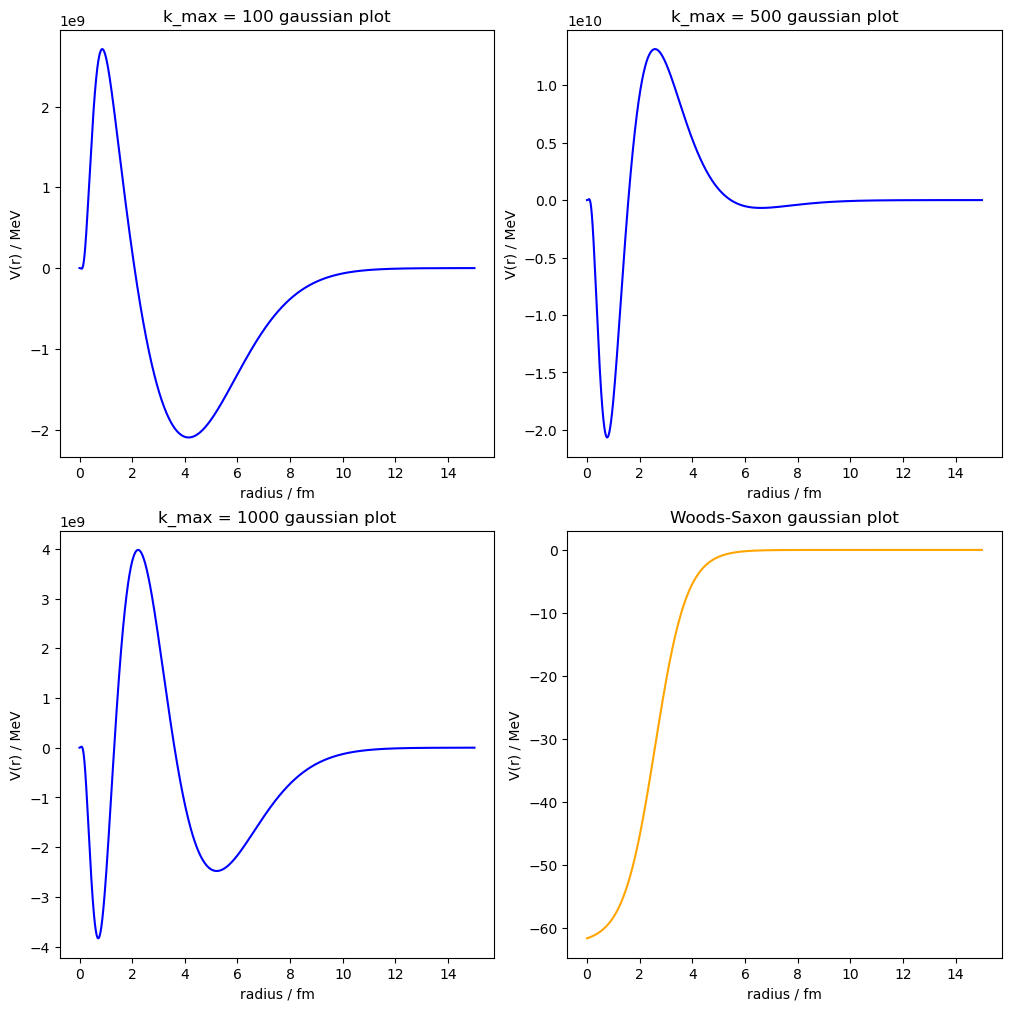

In [26]:
fig = plt.figure(figsize=(10, 10), layout='constrained')
spec = fig.add_gridspec(ncols=2, nrows=2)
ax_1 = fig.add_subplot(spec[0, 0])
ax_2 = fig.add_subplot(spec[0, 1])
ax_3 = fig.add_subplot(spec[1, 0])
ax_4 = fig.add_subplot(spec[1, 1])

ax_1_text_to_annotate = (f'Paramater Values\n'
                        rf'$\sigma_0$ = ({k_max_100_coefficients[0]}) × $10^{{-5}}$ $m^{{-1}}$''\n')
ax_2_text_to_annotate = ''
ax_3_text_to_annotate = ''
ax_4_text_to_annotate = ''

ax_1.set_title('k_max = 100 gaussian plot')
ax_1.set_xlabel('radius / fm')
ax_1.set_ylabel('V(r) / MeV')
ax_1.plot(r_vals, full_gaussian_potential(r_vals, k_max_100_coefficients), label='Expanded Gaussian Potential', color='blue')
#ax_1.plot(r_vals, full_ws_potential(r_vals), label='Woods saxon potential')
#ax_1.annotate(ax_1_text_to_annotate, xy=(0.16, 0.14), xycoords='figure fraction',
#              fontsize='16', bbox=dict(boxstyle="square,pad=.5", fc="white"))
# ax_1.legend(loc='lower right')

ax_2.set_title('k_max = 500 gaussian plot')
ax_2.set_xlabel('radius / fm')
ax_2.set_ylabel('V(r) / MeV')
ax_2.plot(r_vals, full_gaussian_potential(r_vals, k_max_500_coefficients), label='Expanded Gaussian Potential', color='blue')
#ax_2.plot(r_vals, full_ws_potential(r_vals), label='Woods saxon potential')
ax_2.annotate(ax_2_text_to_annotate, xy=(0.16, 0.14), xycoords='figure fraction',
              fontsize='16', bbox=dict(boxstyle="square,pad=.5", fc="white"))
#ax_2.legend(loc='lower right')

ax_3.set_title('k_max = 1000 gaussian plot')
ax_3.set_xlabel('radius / fm')
ax_3.set_ylabel('V(r) / MeV')
ax_3.plot(r_vals, full_gaussian_potential(r_vals, k_max_1000_coefficients), label='Expanded Gaussian Potential', color='blue')
#ax_3.plot(r_vals, full_ws_potential(r_vals), label='Woods saxon potential')
ax_3.annotate(ax_3_text_to_annotate, xy=(0.16, 0.14), xycoords='figure fraction',
              fontsize='16', bbox=dict(boxstyle="square,pad=.5", fc="white"))
#ax_3.legend(loc='lower right')

ax_4.set_title('Woods-Saxon gaussian plot')
ax_4.set_xlabel('radius / fm')
ax_4.set_ylabel('V(r) / MeV')
#ax_4.plot(r_vals, full_gaussian_potential(r_vals, k_max_10000_coefficients), label='Expanded Gaussian Potential')
ax_4.plot(r_vals, full_ws_potential(r_vals), label='Woods saxon potential', color='orange')
ax_4.annotate(ax_4_text_to_annotate, xy=(0.16, 0.14), xycoords='figure fraction',
              fontsize='16', bbox=dict(boxstyle="square,pad=.5", fc="white"))
#ax_4.legend(loc='lower right')

plt.savefig('Potentials for numpy linalg lstsq', dpi=300)
plt.show()

Text to annotate
Choice of sigma i, 4.47, 3.16, 2.23, 1.58, 1.12, 0.791